# Курсовое домашнее задание

Ссылка на соревнование kaggle: https://www.kaggle.com/competitions/fall-ml2-mipt-2023/overview

Критерий качества $-$ функция потерь MSE.

## 1) Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/fall-ml2-mipt-2023.zip"

Archive:  /content/drive/MyDrive/fall-ml2-mipt-2023.zip
  inflating: sample.csv              
  inflating: test.csv                
  inflating: train.csv               


In [4]:
df = pd.read_csv("train.csv", index_col=False)
df = df.drop(columns='Id')

In [5]:
df.head()

,Category,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
0,459.509469,-0.328499,1.175144,0.515354,0.293739,0.717413,0.499106,-0.163973,-0.356333,-0.439508,...,-0.069074,0.163611,0.827213,-0.766158,0.628716,0.608708,0.895262,-0.430845,0.222054,-1.378243
1,681.872699,-0.464213,1.104540,-0.489935,-0.956223,-0.280793,0.005371,1.176738,0.158388,0.231923,...,0.528232,0.963157,0.673927,0.271933,-1.245576,0.451102,-0.876329,0.099235,-2.883061,0.219429
2,2087.125600,-1.547788,1.717030,-0.829589,0.661784,-0.537492,0.147143,0.359703,-0.163511,0.840473,...,-1.871161,1.509097,-0.330102,-1.290021,-0.313704,0.064516,1.056933,1.029114,-1.197726,0.317935
3,663.957725,0.351038,-0.070387,0.253418,-0.199843,-0.811106,0.338446,0.658384,0.808466,-0.990371,...,0.065048,0.333310,-1.605971,0.963046,-1.889288,-1.079422,-0.695426,0.096945,-1.142165,0.377868
4,2903.251134,-1.081837,-2.220129,0.422766,-2.795604,-1.065393,-0.378428,0.929238,-0.381571,-1.757911,...,-1.322272,0.352543,-1.292785,-1.270267,0.762935,-0.784592,1.183498,-0.260315,2.517893,0.713963


In [6]:
target = 'Category'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Columns: 101 entries, Category to x_100
dtypes: float64(101)
memory usage: 6.9 MB


Решим задачу с использованием различных архитектур. На инференс отправим ту, что выдаёт наибольший скор (точнее, наименьший лосс MSE) на валидации. Имплементируем следующие модели:

1. Линейная регрессия

2. Градиентный бустинг

3. Нейросеть

Предположу, что лучше всего с задачей справится градиентный бустинг. Данных не очень много, градиентный бустинг скорее всего сможет уловить закон природы данных.

## 2) Предобработка данных

Избавимся от nan'ов, изучим признаковое описание объектов (например, есть ли категориальные фичи) и разрешим другие аномалии, если такие присутствуют:

In [8]:
all(val == 0 for val in df.isna().sum())

True

Все фичи в датасете являются числовыми (см. выход команды  ```df.info() ```
)


In [9]:
n_features = df.shape[1] - 1

Удалим дубликаты из датасета, если таковые есть:

In [10]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 0 to 8999
Columns: 101 entries, Category to x_100
dtypes: float64(101)
memory usage: 7.0 MB


Таким образом, дубликатов в датасете не было.

## 3) Визуальный анализ данных

Выполним визуальный анализ данных, чтобы облегчить себе дальнейшую работу. Возможно нам удастся уловить определённые зависимости, избавиться от выбросов или произвести другие важные наблюдения.

### Базовые техники

In [11]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, train_size=0.9)

Посмотрим на распределение таргета:

<Axes: ylabel='Density'>

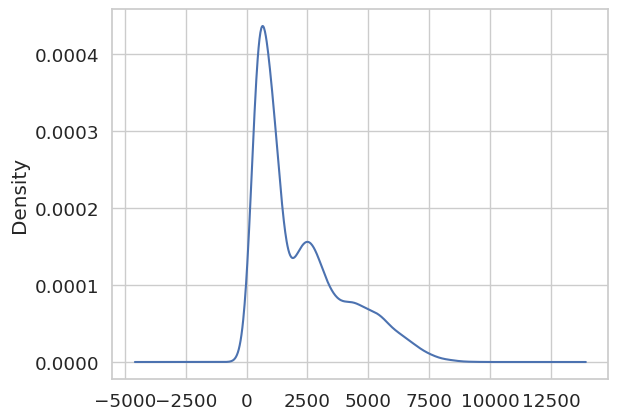

In [12]:
sns.set(style='whitegrid', font_scale=1.2)

train_df['Category'].plot(kind='kde')

#### Анализ корреляции

Посмотрим, как сильно фичи коррелируют между собой:

In [13]:
corr = train_df.corr()
corr.describe()

,Category,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.008000,0.009395,0.009703,0.009478,0.009107,0.010158,0.009304,0.011503,0.009706,0.008332,...,0.009462,0.008963,0.010169,0.010606,0.008515,0.011242,0.010114,0.009592,0.009110,0.010205
std,0.102500,0.100392,0.100004,0.100234,0.100313,0.100009,0.100164,0.099986,0.100045,0.100332,...,0.100106,0.100329,0.100045,0.100003,0.100449,0.100135,0.100047,0.100104,0.100284,0.100296
min,-0.078851,-0.030866,-0.021677,-0.038128,-0.028586,-0.024744,-0.027248,-0.022881,-0.023853,-0.033144,...,-0.023135,-0.052468,-0.026969,-0.031853,-0.038848,-0.049775,-0.019403,-0.024758,-0.031801,-0.033442
25%,-0.015289,-0.010325,-0.006911,-0.007823,-0.008756,-0.007393,-0.007324,-0.005150,-0.006279,-0.010626,...,-0.007788,-0.007050,-0.007009,-0.004392,-0.008749,-0.004921,-0.008060,-0.008107,-0.006809,-0.008207
50%,-0.001766,-0.000755,-0.000974,-0.000093,-0.001893,0.001053,-0.000829,0.001751,-0.000942,-0.000761,...,-0.000625,-0.000237,0.000062,0.001638,-0.000151,0.002770,0.000362,-0.000625,-0.000615,-0.000868
75%,0.009249,0.007587,0.004041,0.008301,0.005997,0.007944,0.006418,0.008904,0.006965,0.006184,...,0.008088,0.006864,0.008236,0.006958,0.007334,0.008361,0.007314,0.006695,0.007106,0.010162
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
corr = corr.unstack()
sorted = corr.sort_values(kind="quicksort", ascending=False)

In [15]:
sorted[n_features:]

x_100     x_100       1.000000
Category  x_81        0.086719
x_81      Category    0.086719
x_80      Category    0.071877
Category  x_80        0.071877
                        ...   
          x_92       -0.052468
          x_82       -0.058633
x_82      Category   -0.058633
x_83      Category   -0.078851
Category  x_83       -0.078851
Length: 10101, dtype: float64

Посмотрим на корреляцию между таргетом и фичами:

In [16]:
corr = train_df.corr()

Text(0.5, 1.0, 'Correlation between features and target')

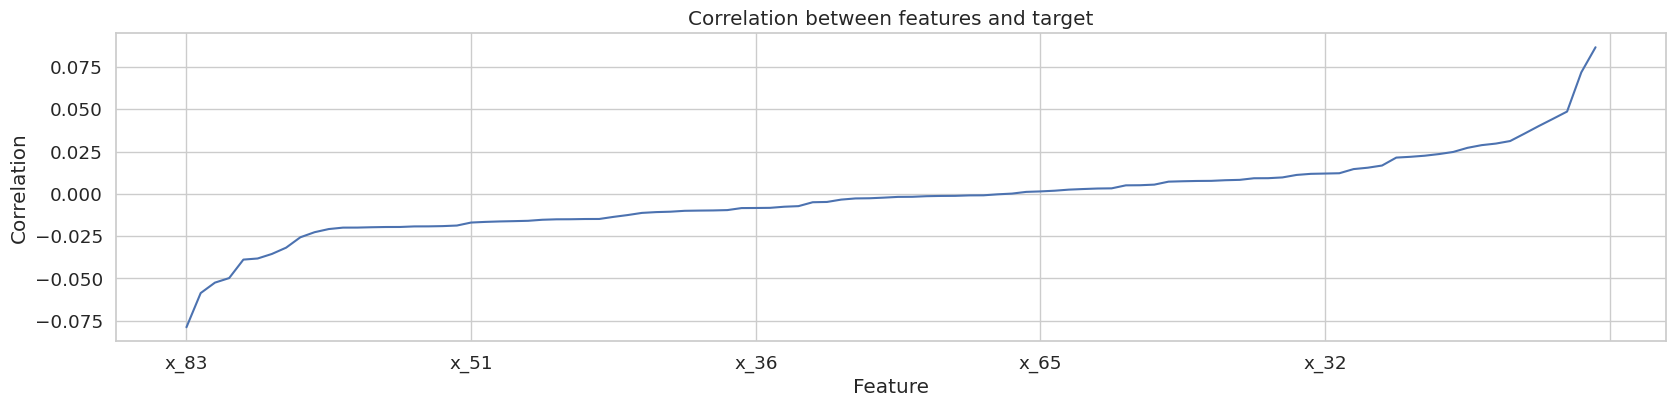

In [17]:
plt.figure(figsize=(20, 4))
corr['Category'][1:].sort_values().plot()

plt.ylabel('Correlation')
plt.xlabel('Feature')
plt.title('Correlation between features and target')

Таким образом, фичи слабо коррелируют между собой. Более того, все фичи слабо коррелируют и с таргетом. Для наглядности выведем часть хитмапы:

<Axes: >

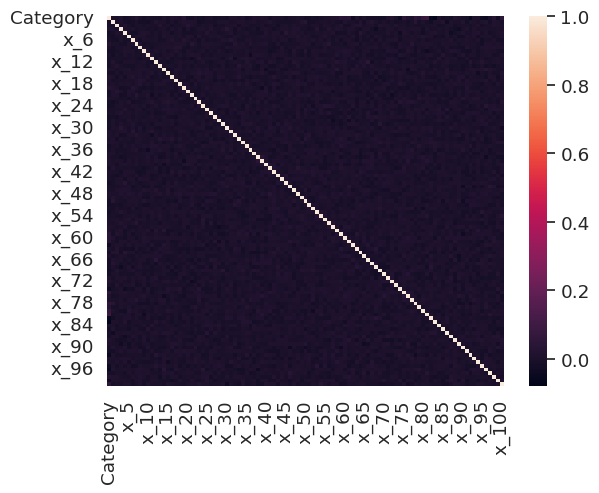

In [18]:
sns.heatmap(train_df.corr())

#### Удаление выбросов

Избавимся от выбросов в тренировочной выборке:

In [19]:
train_data = {
    'with outliers': train_df.copy(),
    'no outliers': train_df.copy()
}

In [20]:
def drop_outlier(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.

    filter = (data[column_name] >= Q1 - 1.5 * IQR) & (data[column_name] <= Q3 + 1.5 *IQR)
    data = data.loc[filter]
    return data

In [21]:
for col in train_data['no outliers'].columns:
    train_data['no outliers'] = drop_outlier(train_data['no outliers'], col)

In [22]:
train_data['no outliers'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3912 entries, 368 to 949
Columns: 101 entries, Category to x_100
dtypes: float64(101)
memory usage: 3.0 MB


In [23]:
train_data['with outliers'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8100 entries, 368 to 949
Columns: 101 entries, Category to x_100
dtypes: float64(101)
memory usage: 6.3 MB


Больше половины данных посчитались выбросами. Возможно, удаление такого большого числа сэмплов ни к чему хорошему не приведёт, поэтому будем работать с двумя датасетами $-$ с "выбросами" и без.

## 4) Experiment

In [24]:
def submit_prediction(model, label):
    test_df = pd.read_csv("test.csv").drop(columns='Id')
    test_features = np.array(test_df)
    preds = model.predict(test_features)
    prediction = pd.DataFrame(preds, columns=[target]).to_csv(f'prediction_{label}.csv', index_label='Id')

#### Градиентный бустинг

Для моделей данного типа нормализация данных не требуется.

In [25]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.2 MB/s eta 0:00:00


In [26]:
from catboost import CatBoostRegressor

In [27]:
val_features = np.array(val_df.drop(columns=target))
val_targets = np.array(val_df[target])

In [28]:
def rmse_loss(model, features, targets):
    preds = model.predict(features)
    return np.sqrt(mean_squared_error(preds, targets))

In [29]:
def fit_gb(lr=1):
    best_loss = 1e9
    catboost_regressor = None

    for key in train_data:
        print(f"train_data[{key}]...")

        train_features = np.array(train_data[key].drop(columns=target))
        train_targets = np.array(train_data[key][target])

        model = CatBoostRegressor(iterations=50, learning_rate=lr, depth=16, loss_function='RMSE', task_type="GPU")
        model.fit(train_features, train_targets, verbose=True)

        loss = rmse_loss(model, val_features, val_targets)
        if loss < best_loss:
            catboost_regressor = model
            best_loss = loss

        print(f"rmse loss on val: {loss}")

    return catboost_regressor

In [30]:
catboost_regressor = fit_gb()

train_data[with outliers]...
0:	learn: 1436.5151578	total: 607ms	remaining: 29.7s
1:	learn: 1116.8032827	total: 1.13s	remaining: 27s
2:	learn: 915.7298993	total: 1.61s	remaining: 25.2s
3:	learn: 738.7151208	total: 2.09s	remaining: 24s
4:	learn: 587.3282465	total: 2.62s	remaining: 23.6s
5:	learn: 463.6153365	total: 3.14s	remaining: 23s
6:	learn: 371.2125370	total: 3.63s	remaining: 22.3s
7:	learn: 294.0167393	total: 4.17s	remaining: 21.9s
8:	learn: 235.0216675	total: 4.66s	remaining: 21.2s
9:	learn: 191.3151985	total: 5.17s	remaining: 20.7s
10:	learn: 154.1864063	total: 5.7s	remaining: 20.2s
11:	learn: 121.3449242	total: 6.21s	remaining: 19.7s
12:	learn: 97.0922840	total: 6.72s	remaining: 19.1s
13:	learn: 76.7504245	total: 7.25s	remaining: 18.6s
14:	learn: 66.5243889	total: 7.82s	remaining: 18.2s
15:	learn: 52.6981036	total: 8.44s	remaining: 17.9s
16:	learn: 43.6404473	total: 9.03s	remaining: 17.5s
17:	learn: 35.1188089	total: 9.62s	remaining: 17.1s
18:	learn: 29.1718345	total: 10.2s	rem

Таким образом, при обучении модели на данных без выбросов мы достигаем большего скора на валидации. Заметим, что модель переобучилась.

In [31]:
submit_prediction(catboost_regressor, "catboost_regressor_no_outliers")

Итак, скор на инференсе:

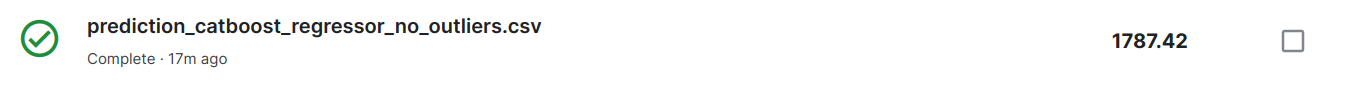

Попробуем избавиться от переобучения обновлением lr. Можно было перебирать его по сетке, но при ```lr = 1e-3``` модель почти не переобучается:

In [32]:
catboost_regressor = fit_gb(lr=1e-3)

train_data[with outliers]...
0:	learn: 1815.1502880	total: 518ms	remaining: 25.4s
1:	learn: 1814.7451759	total: 1.07s	remaining: 25.7s
2:	learn: 1814.3167704	total: 1.68s	remaining: 26.4s
3:	learn: 1813.9025512	total: 2.24s	remaining: 25.7s
4:	learn: 1813.5250443	total: 2.75s	remaining: 24.7s
5:	learn: 1813.1045782	total: 3.28s	remaining: 24s
6:	learn: 1812.6838052	total: 3.79s	remaining: 23.3s
7:	learn: 1812.2547729	total: 4.31s	remaining: 22.6s
8:	learn: 1811.8381984	total: 4.83s	remaining: 22s
9:	learn: 1811.4801511	total: 5.32s	remaining: 21.3s
10:	learn: 1811.1135869	total: 5.79s	remaining: 20.5s
11:	learn: 1810.7040110	total: 6.29s	remaining: 19.9s
12:	learn: 1810.2798169	total: 6.82s	remaining: 19.4s
13:	learn: 1809.8612511	total: 7.34s	remaining: 18.9s
14:	learn: 1809.4685787	total: 7.82s	remaining: 18.3s
15:	learn: 1809.0535290	total: 8.32s	remaining: 17.7s
16:	learn: 1808.6310447	total: 8.84s	remaining: 17.2s
17:	learn: 1808.2517382	total: 9.37s	remaining: 16.7s
18:	learn: 18

Переобучение, конечно, всё равно присутствует, но засчёт небольшого lr мы добиваемся лучшего качества на валидации.

In [33]:
submit_prediction(catboost_regressor, "catboost_regressor_no_outliers")

Итак, скор на инференсе:

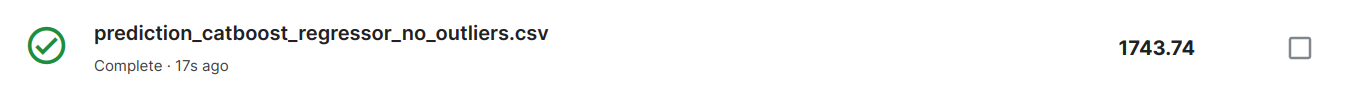

In [34]:
catboost_regressor = fit_gb(lr=5 * 1e-4)

train_data[with outliers]...
0:	learn: 1815.3542029	total: 491ms	remaining: 24.1s
1:	learn: 1815.1516113	total: 979ms	remaining: 23.5s
2:	learn: 1814.9373646	total: 1.48s	remaining: 23.2s
3:	learn: 1814.7301287	total: 1.98s	remaining: 22.8s
4:	learn: 1814.5414015	total: 2.46s	remaining: 22.2s
5:	learn: 1814.3310545	total: 2.96s	remaining: 21.7s
6:	learn: 1814.1204740	total: 3.46s	remaining: 21.3s
7:	learn: 1813.9058268	total: 3.97s	remaining: 20.9s
8:	learn: 1813.6972184	total: 4.47s	remaining: 20.4s
9:	learn: 1813.5180734	total: 4.95s	remaining: 19.8s
10:	learn: 1813.3345882	total: 5.42s	remaining: 19.2s
11:	learn: 1813.1295397	total: 5.92s	remaining: 18.7s
12:	learn: 1812.9171461	total: 6.43s	remaining: 18.3s
13:	learn: 1812.7075870	total: 6.93s	remaining: 17.8s
14:	learn: 1812.5109072	total: 7.42s	remaining: 17.3s
15:	learn: 1812.3030450	total: 7.92s	remaining: 16.8s
16:	learn: 1812.0913917	total: 8.43s	remaining: 16.4s
17:	learn: 1811.9013431	total: 8.92s	remaining: 15.9s
18:	learn

In [35]:
submit_prediction(catboost_regressor, "catboost_regressor_no_outliers")

Скор на инференсе:

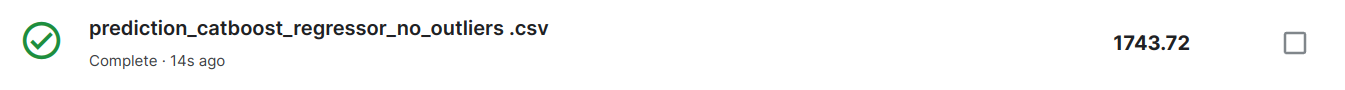

Отличается от предыдущего скора во втором знаке после запятой.

**Замечание.** Для борьбы с переобучением можно добавить новые статистики в качестве фичей. Генерация новых признаков будет позже.

#### Линейная регрессия

##### Аналитическое решение

Заметим, что скорее всего фичи датасета имеют нормальное распределение:

<Axes: ylabel='Density'>

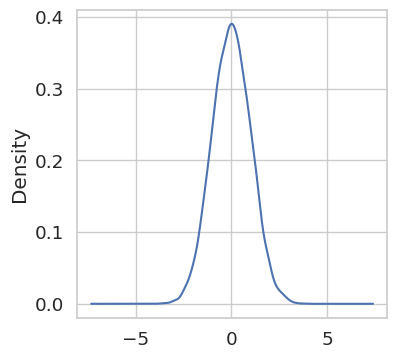

In [36]:
plt.figure(figsize=(4, 4))
train_df['x_40'].plot(kind='kde')

In [37]:
val_features = np.array(val_df.drop(columns=target))
val_targets = np.array(val_df[target])

Проверим предположение, что фичи принадлежат нормальному распределению:

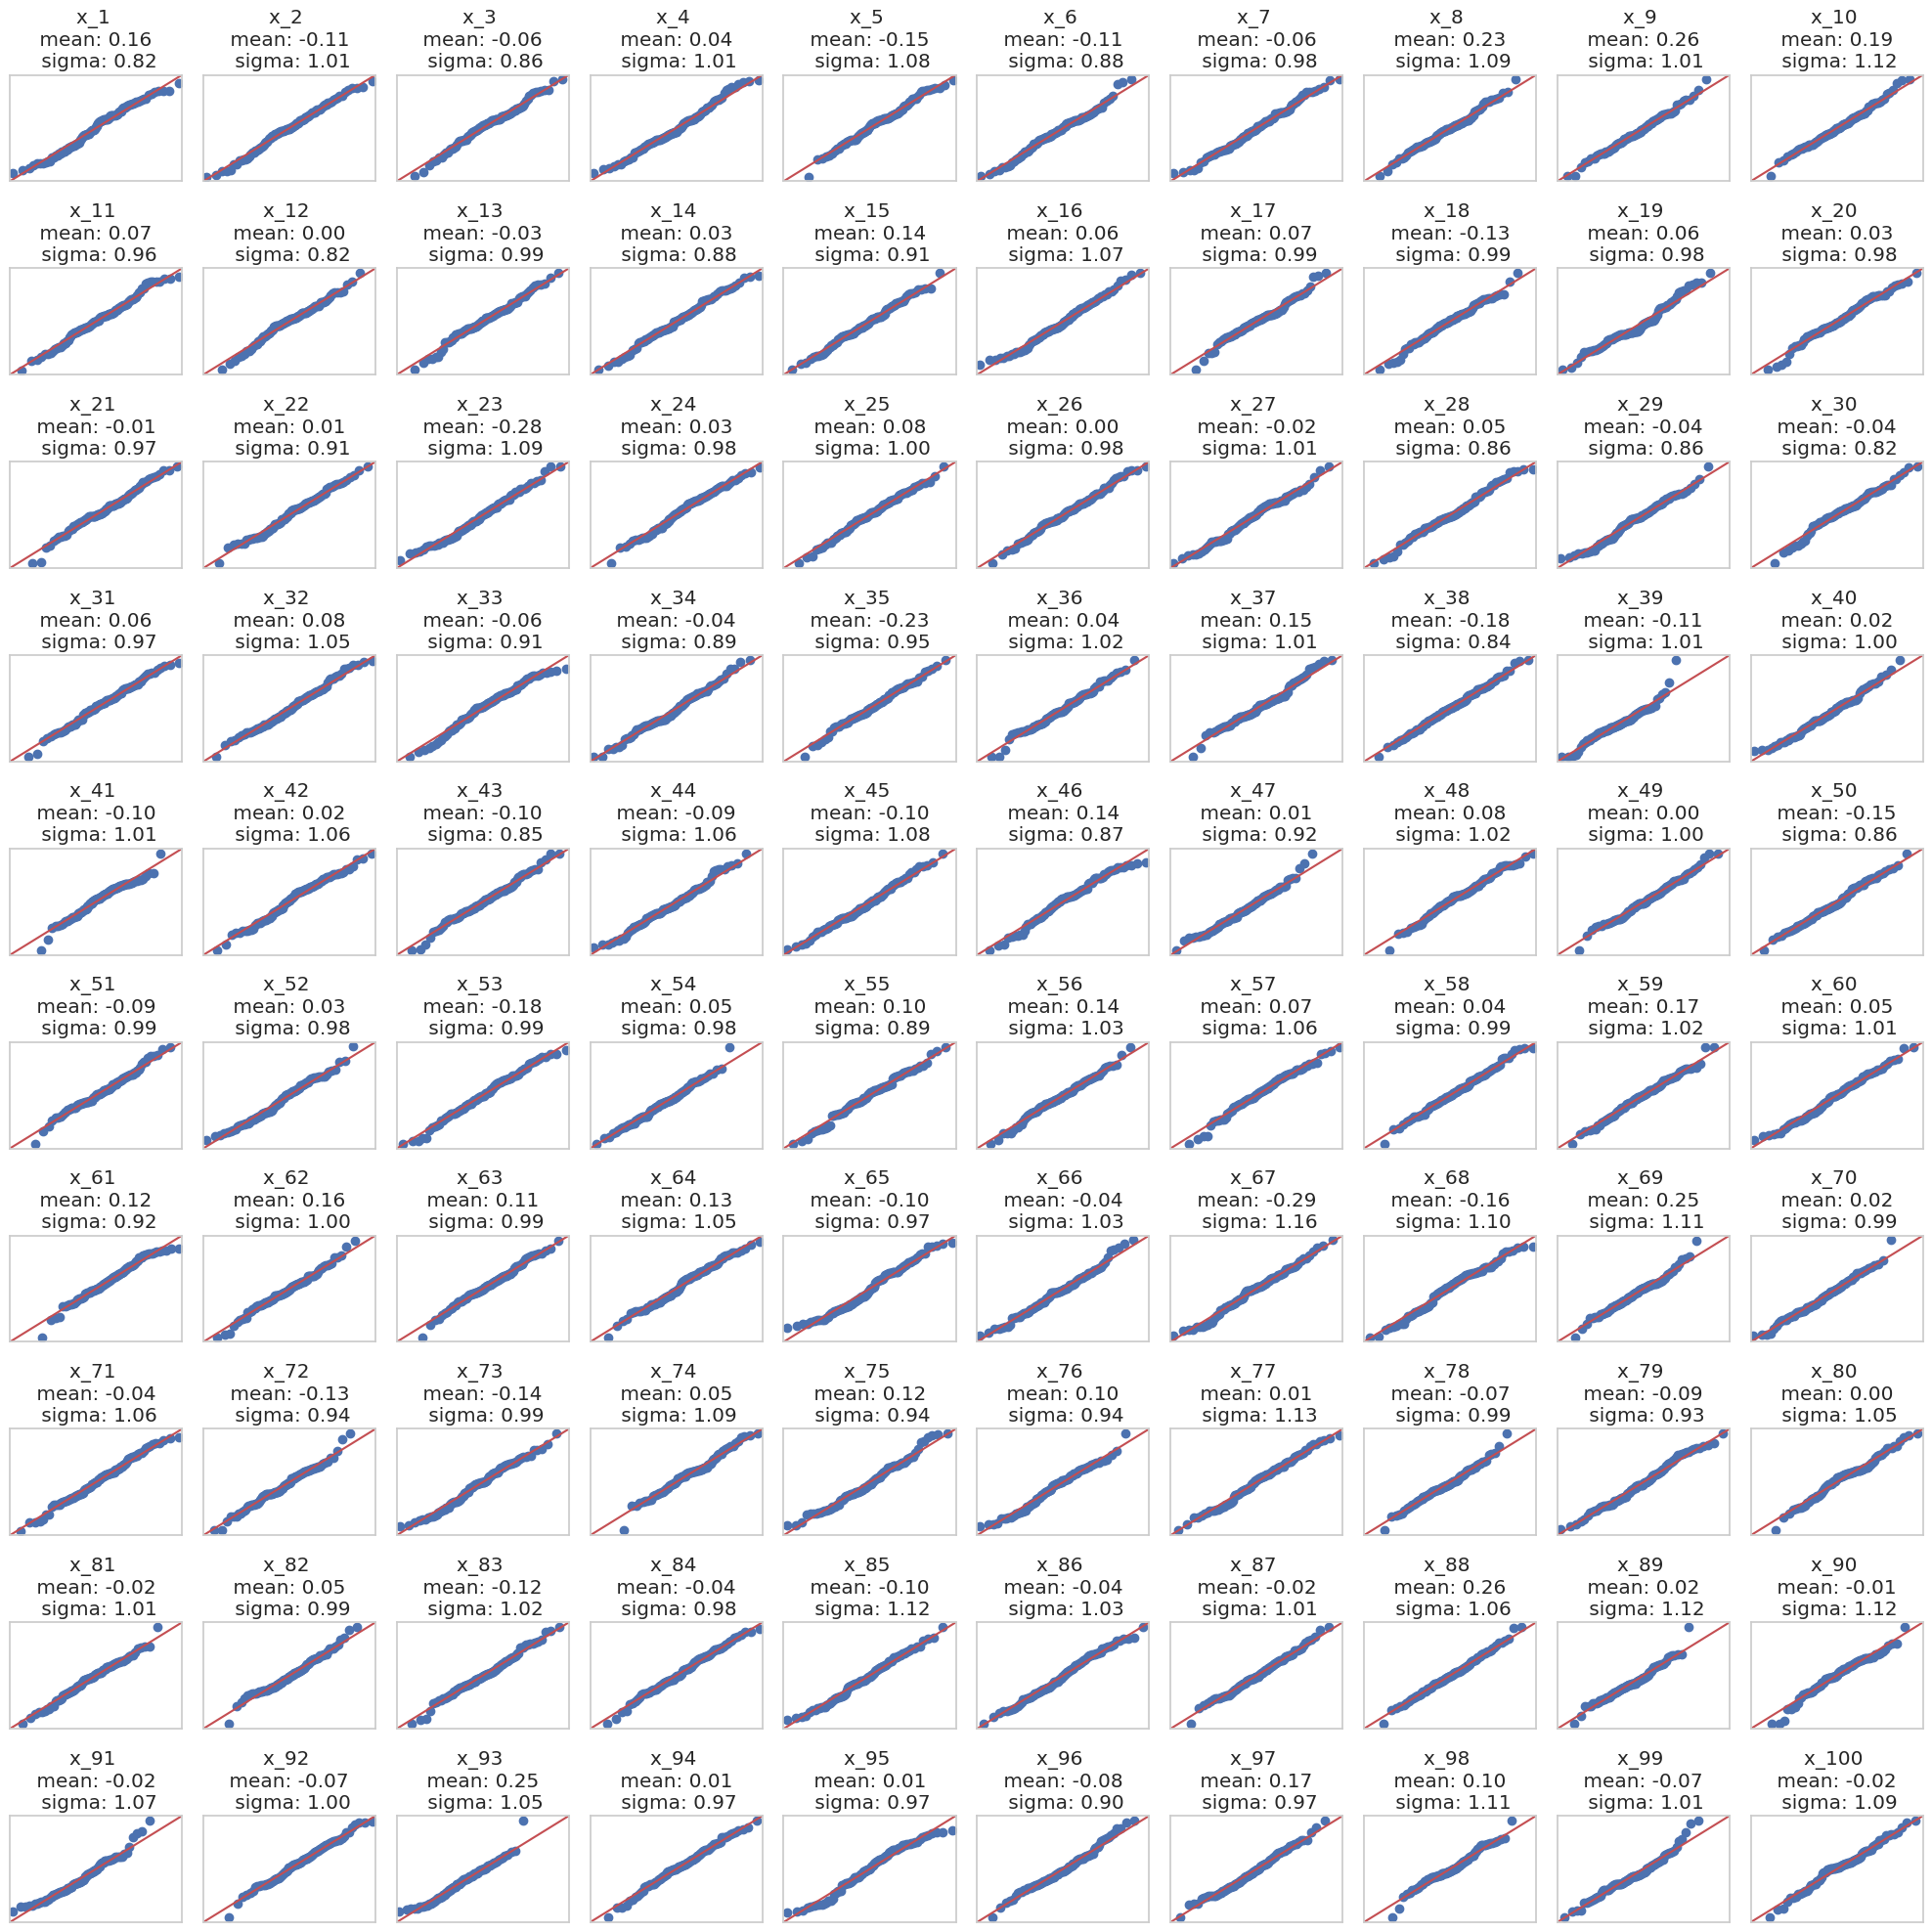

In [38]:
import statsmodels.api as sm
from scipy import stats as sps

figure, axes = plt.subplots(10, 10, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for row in range(10):
    for col in range(10):
        feature_id = row * 10 + col

        train_features = np.array(train_data['with outliers'].drop(columns=target))

        mean = train_features[feature_id].mean()
        sigma = np.cov(train_features[feature_id])**0.5
        sample_normal = sps.norm(loc=mean, scale=sigma)
        sm.qqplot(train_features[feature_id], sample_normal, line='45', ax=axes[row][col])
        axes[row][col].set_xticks([]); axes[row][col].set_yticks([]);
        axes[row][col].set_xlabel(''); axes[row][col].set_ylabel('');
        axes[row][col].set_title(f'x_{feature_id + 1} \n mean: {mean:.2f} \n sigma: {sigma:.2f}')

plt.tight_layout()
plt.show()

Действительно, фичи почти что распределены нормально. Тогда воспользуемся теоремой Гаусса о Best Linear Unbiased Estimator и найдём аналитическое решение:

In [39]:
def get_blue(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

In [40]:
def lin_reg_rmse_loss(w, features, targets):
    preds = features @ w
    return np.sqrt(mean_squared_error(preds, targets))

In [41]:
def fit_analyt_lin_reg(fit_intercept=True):
    best_loss = 1e9
    best_w = None
    best_scaler = None

    for key in train_data:
        print(f"train_data[{key}]...")

        scaler = StandardScaler()

        train_features = np.array(train_data[key].drop(columns=target))
        train_targets = np.array(train_data[key][target])

        train_features_scaled = scaler.fit_transform(train_features)
        val_features_scaled = scaler.transform(val_features)

        if fit_intercept:
            train_features_scaled = np.hstack((train_features_scaled,
                                              np.ones((train_features_scaled.shape[0], 1))))
            val_features_scaled = np.hstack((val_features_scaled,
                                              np.ones((val_features_scaled.shape[0], 1))))

        print(train_features_scaled.shape)

        w = get_blue(train_features_scaled, train_targets)

        loss = lin_reg_rmse_loss(w, val_features_scaled, val_targets)
        if loss < best_loss:
            best_w = w
            best_scaler = scaler
            best_loss = loss

        train_loss = lin_reg_rmse_loss(w, train_features_scaled, train_targets)
        print(f"Train loss: {train_loss:.4f}, val loss: {loss:.4f}")


    return best_w, best_scaler

In [42]:
fit_intercept = True
w, scaler = fit_analyt_lin_reg(fit_intercept)

train_data[with outliers]...
(8100, 101)
Train loss: 1764.7315, val loss: 1810.0934
train_data[no outliers]...
(3912, 101)
Train loss: 1650.0231, val loss: 1825.5545


In [43]:
test_df = pd.read_csv("test.csv").drop(columns='Id')
test_features = np.array(test_df)
test_features_scaled = scaler.transform(test_features)
if fit_intercept:
    test_features_scaled = np.hstack((test_features_scaled,
                                              np.ones((test_features_scaled.shape[0], 1))))
preds = test_features_scaled @ w
prediction = pd.DataFrame(preds, columns=[target]).to_csv(f'prediction_lin_reg_analyt.csv', index_label='Id')

In [44]:
print(w)

[ 1.34263320e+00 -3.51914859e+00  1.21458315e+01 -2.99812044e+01
 -2.15362694e+01 -3.44680527e+00  4.44923338e+01 -1.39717866e+00
 -2.82756410e+01 -3.26049659e+00 -1.77092772e+01 -1.14597799e+01
 -2.93582282e+01  2.45377681e+01 -1.74172923e+01  2.90086234e+01
  2.61664952e+01  5.96084122e+00  4.90912573e+01 -3.37943972e+01
 -3.12981038e+01 -5.86188147e-01 -1.72507074e+01 -2.86629421e+01
 -1.55452571e+01 -4.76790986e+00 -4.18310880e+01 -1.70134805e+01
 -1.43777295e+01 -3.52896983e+01  1.79232056e+01  1.77512256e+01
 -4.79013265e+00  7.83432007e+00 -2.94440905e+01 -1.08791767e+01
  2.31195351e+01  1.63127655e+00  2.42190421e+01  1.60628475e+01
 -3.42995642e+01  1.25756588e+00  4.60620717e+00 -5.85353548e+00
 -2.81611323e+01 -4.23122244e+00 -4.35164365e+00  2.08686447e+01
 -2.48712349e+00 -2.97785853e+01 -2.97673848e+01 -1.23645165e+01
 -3.43946242e+01 -2.20165723e+01 -9.40448262e-03  8.81532538e-01
  1.09347564e+01  1.52706178e+01  6.54509914e+01  4.63073037e+01
  5.03178525e+01 -5.29723

Скор на инференсе:

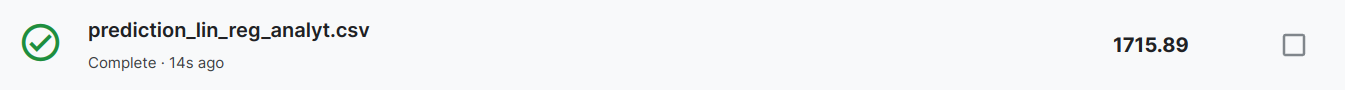

Причём на валидации лучшее значение критерия достигается при обучении на датасете с выбросами.

##### sklearn

###### Аналитическое решение

Сравним наше решение выше с реализацией линейной регрессии библиотеки sklearn:

In [45]:
from sklearn.linear_model import LinearRegression

In [46]:
def fit_lin_reg():
    best_loss = 1e9
    best_linear_model = None

    for key in train_data:
        print(f"train_data[{key}]...")

        scaler = StandardScaler()

        train_features = np.array(train_data[key].drop(columns=target))
        train_targets = np.array(train_data[key][target])

        train_features_scaled = scaler.fit_transform(train_features)
        val_features_scaled = scaler.transform(val_features)

        linear_model = LinearRegression(fit_intercept=True)
        linear_model.fit(train_features_scaled, train_targets)

        loss = rmse_loss(linear_model, val_features_scaled, val_targets)
        if loss < best_loss:
            best_linear_model = linear_model
            best_scaler = scaler
            best_loss = loss

        train_loss = rmse_loss(linear_model, train_features_scaled, train_targets)
        print(f"Train loss: {train_loss:.4f}, val loss: {loss:.4f}")

    return best_linear_model, best_scaler

In [47]:
linear_model, scaler = fit_lin_reg()

train_data[with outliers]...
Train loss: 1764.7315, val loss: 1810.0934
train_data[no outliers]...
Train loss: 1650.0231, val loss: 1825.5545


In [48]:
print(linear_model.coef_, linear_model.intercept_)

[ 1.34263320e+00 -3.51914859e+00  1.21458315e+01 -2.99812044e+01
 -2.15362694e+01 -3.44680527e+00  4.44923338e+01 -1.39717866e+00
 -2.82756410e+01 -3.26049659e+00 -1.77092772e+01 -1.14597799e+01
 -2.93582282e+01  2.45377681e+01 -1.74172923e+01  2.90086234e+01
  2.61664952e+01  5.96084122e+00  4.90912573e+01 -3.37943972e+01
 -3.12981038e+01 -5.86188147e-01 -1.72507074e+01 -2.86629421e+01
 -1.55452571e+01 -4.76790986e+00 -4.18310880e+01 -1.70134805e+01
 -1.43777295e+01 -3.52896983e+01  1.79232056e+01  1.77512256e+01
 -4.79013265e+00  7.83432007e+00 -2.94440905e+01 -1.08791767e+01
  2.31195351e+01  1.63127655e+00  2.42190421e+01  1.60628475e+01
 -3.42995642e+01  1.25756588e+00  4.60620717e+00 -5.85353548e+00
 -2.81611323e+01 -4.23122244e+00 -4.35164365e+00  2.08686447e+01
 -2.48712349e+00 -2.97785853e+01 -2.97673848e+01 -1.23645165e+01
 -3.43946242e+01 -2.20165723e+01 -9.40448262e-03  8.81532538e-01
  1.09347564e+01  1.52706178e+01  6.54509914e+01  4.63073037e+01
  5.03178525e+01 -5.29723

Действительно, как и следовало ожидать, получили ту же самую оценку параметра.

###### Градиентный спуск

Поскольку предположение о том, что фичи распределены нормально, скорее всего неверно, то и аналитическое решение скорее всего не совпадает с оптимальной оценкой параметра. Для поиска оптимальной оценки воспользуемся знаниямии из теории методов оптимизации. Реализации модели линейной регрессии в известных библиотеках основаны на градиентном спуске.

In [49]:
from sklearn.linear_model import SGDRegressor

In [50]:
def fit_lin_reg_gd():
    best_loss = 1e9
    best_regressor = None

    for key in train_data:
        print(f"train_data[{key}]...")

        scaler = StandardScaler()

        train_features = np.array(train_data[key].drop(columns=target))
        train_targets = np.array(train_data[key][target])

        train_features_scaled = scaler.fit_transform(train_features)
        val_features_scaled = scaler.transform(val_features)

        regressor = SGDRegressor(fit_intercept=True, loss='squared_error', penalty='l2')
        regressor.fit(train_features_scaled, train_targets)

        loss = rmse_loss(regressor, val_features_scaled, val_targets)
        if loss < best_loss:
            best_regressor = regressor
            best_scaler = scaler
            best_loss = loss

        train_loss = rmse_loss(regressor, train_features_scaled, train_targets)
        print(f"Train loss: {train_loss:.4f}, val loss: {loss:.4f}")

    return best_regressor, best_scaler

In [51]:
regressor, scaler = fit_lin_reg_gd()

train_data[with outliers]...
Train loss: 1772.3897, val loss: 1824.3396
train_data[no outliers]...
Train loss: 1654.6931, val loss: 1835.1040


Как мы видим, даже на трейне аналитическое решение показывает себя лучше.

#### Нейросеть

In [52]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [53]:
class NN(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.model = nn.Sequential(
            nn.Linear(self.in_features, 8192),
            nn.LeakyReLU(),
            nn.BatchNorm1d(8192),
            nn.Linear(8192, 8192),
            nn.LeakyReLU(),
            nn.BatchNorm1d(8192),
            nn.Linear(8192, 4096),
            nn.LeakyReLU(),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 1)
        )


    def forward(self, x):
        output = self.model(x)

        return output

In [54]:
def eval_epoch(model, criterion, val_loader):
    model.eval()

    running_loss = 0.0
    processed_size = 0

    with torch.no_grad():
        for X, y in val_loader:
            output = model(X.to(device))
            loss = criterion(output, y.to(device))

            running_loss += loss.item() * len(X)
            processed_size += len(X)

    return np.sqrt(running_loss / processed_size)

In [55]:
def fit_epoch(model, criterion, optimizer, train_loader):
    model.train()

    running_loss = 0.0
    processed_size = 0

    for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X.to(device))
        loss = criterion(output, y.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(X)
        processed_size += len(X)

    return np.sqrt(running_loss / processed_size)

In [56]:
from tqdm import tqdm

def train(model, criterion, optimizer, train_loader, val_loader, epochs, scheduler=None):
    loss_history = []

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            train_loss = fit_epoch(model, criterion, optimizer, train_loader)
            val_loss = eval_epoch(model, criterion, val_loader)
            loss_history.append((train_loss, val_loss))
            print(f"Train loss: {train_loss:.3f}, val loss: {val_loss:.3f}")

            if scheduler is not None:
                scheduler.step()

            pbar.update(1)


    return loss_history

In [57]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [58]:
train_features = np.array(train_df.drop(columns=target))
train_targets = np.array(train_df[target])

val_features = np.array(val_df.drop(columns=target))
val_targets = np.array(val_df[target])

test_df = pd.read_csv("test.csv").drop(columns='Id')
test_features = np.array(test_df)

In [59]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

In [60]:
train_features_scaled = torch.Tensor(np.array(train_df.drop(columns=target)))
train_targets = torch.Tensor(np.array(train_df[target]))
train_dataset = TensorDataset(train_features_scaled, train_targets)
train_loader = DataLoader(train_dataset, batch_size=32)

val_features_scaled = torch.Tensor(np.array(val_df.drop(columns=target)))
val_targets = torch.Tensor(np.array(val_df[target]))
val_dataset = TensorDataset(val_features_scaled, val_targets)
val_loader = DataLoader(val_dataset, batch_size=32)

test_df = pd.read_csv("test.csv").drop(columns='Id')
test_features_scaled = torch.Tensor(np.array(test_df))
test_dataset = TensorDataset(test_features_scaled)
test_loader = DataLoader(test_dataset, batch_size=32)

In [61]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [62]:
nn_model = NN(100).to(device)
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=0.25)
criterion = F.mse_loss

history = train(nn_model, criterion, optimizer, train_loader, val_loader, 50)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-55-66464e474378>:10: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = criterion(output, y.to(device))
<ipython-input-55-66464e474378>:10: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = criterion(output, y.to(device))
  2%|▏         | 1/50 [00:14<11:54, 14.57s/it]

Train loss: 1868.263, val loss: 1814.688


  4%|▍         | 2/50 [00:26<10:22, 12.97s/it]

Train loss: 1855.450, val loss: 1813.742


  6%|▌         | 3/50 [00:37<09:24, 12.00s/it]

Train loss: 1840.109, val loss: 1817.951


  8%|▊         | 4/50 [00:48<08:50, 11.52s/it]

Train loss: 1837.897, val loss: 1827.626


 10%|█         | 5/50 [00:58<08:27, 11.27s/it]

Train loss: 1832.842, val loss: 1815.557


 12%|█▏        | 6/50 [01:09<08:08, 11.11s/it]

Train loss: 1832.262, val loss: 1819.779


 14%|█▍        | 7/50 [01:20<07:52, 10.99s/it]

Train loss: 1832.103, val loss: 1833.471


 16%|█▌        | 8/50 [01:31<07:39, 10.94s/it]

Train loss: 1834.639, val loss: 1816.545


 18%|█▊        | 9/50 [01:42<07:26, 10.90s/it]

Train loss: 1830.223, val loss: 1813.110


 20%|██        | 10/50 [01:52<07:13, 10.85s/it]

Train loss: 1833.639, val loss: 1813.844


 22%|██▏       | 11/50 [02:03<07:02, 10.84s/it]

Train loss: 1829.785, val loss: 1835.253


 24%|██▍       | 12/50 [02:14<06:51, 10.83s/it]

Train loss: 1832.257, val loss: 1819.496


 26%|██▌       | 13/50 [02:25<06:39, 10.81s/it]

Train loss: 1831.275, val loss: 1828.728


 28%|██▊       | 14/50 [02:35<06:29, 10.81s/it]

Train loss: 1834.722, val loss: 1814.791


 30%|███       | 15/50 [02:46<06:18, 10.82s/it]

Train loss: 1830.102, val loss: 1814.351


 32%|███▏      | 16/50 [02:57<06:07, 10.79s/it]

Train loss: 1841.102, val loss: 1813.626


 34%|███▍      | 17/50 [03:08<05:56, 10.80s/it]

Train loss: 1830.336, val loss: 1815.204


 36%|███▌      | 18/50 [03:19<05:45, 10.81s/it]

Train loss: 1832.414, val loss: 1848.469


 38%|███▊      | 19/50 [03:29<05:34, 10.79s/it]

Train loss: 1837.433, val loss: 1814.225


 40%|████      | 20/50 [03:40<05:23, 10.79s/it]

Train loss: 1829.667, val loss: 1814.091


 42%|████▏     | 21/50 [03:51<05:13, 10.80s/it]

Train loss: 1832.886, val loss: 1814.262


 44%|████▍     | 22/50 [04:02<05:01, 10.78s/it]

Train loss: 1832.479, val loss: 1813.626


 46%|████▌     | 23/50 [04:13<04:51, 10.78s/it]

Train loss: 1834.557, val loss: 1813.608


 48%|████▊     | 24/50 [04:23<04:40, 10.80s/it]

Train loss: 1832.212, val loss: 1813.326


 50%|█████     | 25/50 [04:34<04:29, 10.79s/it]

Train loss: 1835.618, val loss: 1848.004


 52%|█████▏    | 26/50 [04:45<04:18, 10.78s/it]

Train loss: 1831.729, val loss: 1820.770


 54%|█████▍    | 27/50 [04:56<04:08, 10.82s/it]

Train loss: 1831.103, val loss: 1816.541


 56%|█████▌    | 28/50 [05:07<03:58, 10.83s/it]

Train loss: 1836.989, val loss: 1813.518


 58%|█████▊    | 29/50 [05:18<03:47, 10.83s/it]

Train loss: 1837.768, val loss: 1851.184


 60%|██████    | 30/50 [05:28<03:36, 10.81s/it]

Train loss: 1832.592, val loss: 1814.567


 62%|██████▏   | 31/50 [05:39<03:25, 10.80s/it]

Train loss: 1835.834, val loss: 1814.650


 64%|██████▍   | 32/50 [05:50<03:14, 10.81s/it]

Train loss: 1836.979, val loss: 1813.317


 66%|██████▌   | 33/50 [06:01<03:03, 10.80s/it]

Train loss: 1831.566, val loss: 1832.059


 68%|██████▊   | 34/50 [06:11<02:52, 10.80s/it]

Train loss: 1831.447, val loss: 1814.241


 70%|███████   | 35/50 [06:22<02:42, 10.82s/it]

Train loss: 1838.041, val loss: 1816.258


 72%|███████▏  | 36/50 [06:33<02:31, 10.81s/it]

Train loss: 1832.969, val loss: 1839.277


 74%|███████▍  | 37/50 [06:44<02:20, 10.81s/it]

Train loss: 1838.419, val loss: 1825.006


 76%|███████▌  | 38/50 [06:55<02:09, 10.82s/it]

Train loss: 1830.352, val loss: 1829.896


 78%|███████▊  | 39/50 [07:06<01:59, 10.82s/it]

Train loss: 1830.092, val loss: 1814.349


 80%|████████  | 40/50 [07:16<01:48, 10.82s/it]

Train loss: 1833.448, val loss: 1823.127


 82%|████████▏ | 41/50 [07:27<01:37, 10.84s/it]

Train loss: 1830.632, val loss: 1826.970


 84%|████████▍ | 42/50 [07:38<01:26, 10.84s/it]

Train loss: 1838.560, val loss: 1815.995


 86%|████████▌ | 43/50 [07:49<01:15, 10.83s/it]

Train loss: 1829.019, val loss: 1813.951


 88%|████████▊ | 44/50 [08:00<01:04, 10.83s/it]

Train loss: 1831.512, val loss: 1819.339


 90%|█████████ | 45/50 [08:11<00:54, 10.83s/it]

Train loss: 1838.012, val loss: 1814.689


 92%|█████████▏| 46/50 [08:21<00:43, 10.82s/it]

Train loss: 1832.522, val loss: 1824.396


 94%|█████████▍| 47/50 [08:32<00:32, 10.82s/it]

Train loss: 1833.714, val loss: 1815.121


 96%|█████████▌| 48/50 [08:43<00:21, 10.82s/it]

Train loss: 1830.236, val loss: 1823.712


 98%|█████████▊| 49/50 [08:54<00:10, 10.80s/it]

Train loss: 1836.195, val loss: 1813.288


100%|██████████| 50/50 [09:05<00:00, 10.90s/it]

Train loss: 1838.195, val loss: 1850.148


In [63]:
test_df = pd.read_csv("test.csv").drop(columns='Id')
test_features = np.array(test_df)
test_features_scaled = scaler.transform(test_features)
preds = nn_model(torch.Tensor(test_features_scaled).to(device))
prediction = pd.DataFrame(preds.detach().cpu(), columns=[target]).to_csv(f'prediction_nn.csv', index_label='Id')

Скор на инференсе:

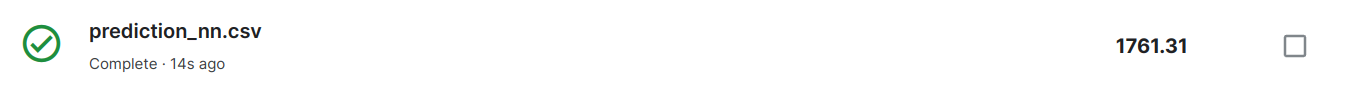

## 5) Feature selection

### Feature reduction

Попробуем уменьшить количество фичей и оставить только самые важные при помощи PCA.

In [64]:
from sklearn.decomposition import PCA

In [65]:
pca = PCA()
train_features_scaled_pca = pca.fit_transform(train_features_scaled)

Отметим, что pca обучается на отнормированных данных.

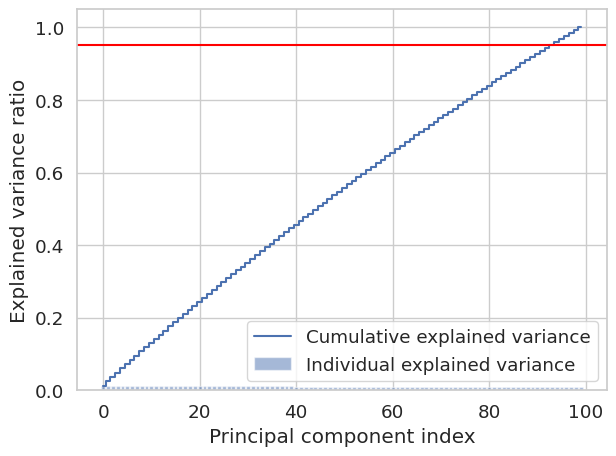

In [66]:
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=0.95, c='red')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')

plt.legend(loc='best')
plt.tight_layout()
plt.grid(True)
plt.show()

Сравним сингулярные значения компонент. Чем больше сингулярное значение, тем больше соответствующее значение дисперсии.

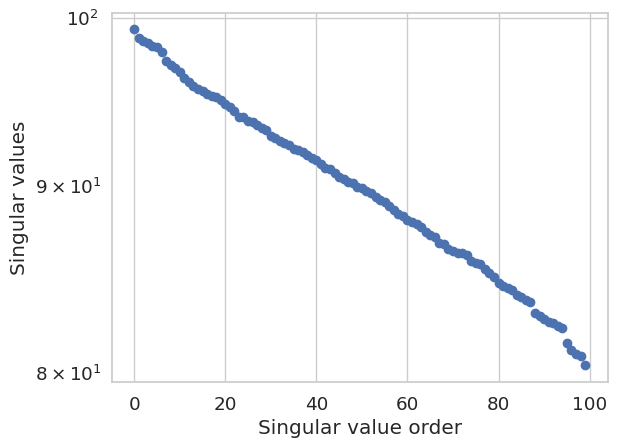

In [67]:
u, singular_values, tmp = np.linalg.svd(train_features_scaled)
plt.plot(singular_values, 'bo')

plt.ylabel("Singular values")
plt.xlabel("Singular value order")
plt.yscale('log')

plt.grid(True)

### Experiment

#### Линейная регрессия

Исследуем зависимость качества аналитического решения на валидации от числа используемых компонент:

In [68]:
def fit_lin_reg(n_components):
    linear_model = {}
    scaler = {}
    pca = {}
    loss = {}

    for key in train_data:
        print(f"train_data[{key}]...")

        scaler[key] = StandardScaler()

        train_features = np.array(train_data[key].drop(columns=target))
        train_targets = np.array(train_data[key][target])

        pca[key] = PCA(n_components=n_components)
        train_features_pca = pca[key].fit_transform(train_features)
        val_features_pca = pca[key].transform(val_features)

        train_features_pca_scaled = scaler[key].fit_transform(train_features_pca)
        val_features_pca_scaled = scaler[key].transform(val_features_pca)

        linear_model[key] = LinearRegression(fit_intercept=True)
        linear_model[key].fit(train_features_pca_scaled, train_targets)

        val_loss = rmse_loss(linear_model[key], val_features_pca_scaled, val_targets)

        train_loss = rmse_loss(linear_model[key], train_features_pca_scaled, train_targets)
        loss[key] = (train_loss, val_loss)
        print(f"Train loss: {loss[key][0]}, val loss: {loss[key][1]}")

    return linear_model, pca, scaler, loss

In [69]:
from sklearn.metrics import mean_squared_error

components = []
models_list = []
pca_list = []
scalers_list = []
loss_list = {
    'with outliers': [],
    'no outliers': []
}

for n_components in range(20, 100 + 1):
    print(f"components: {n_components}")
    linear_model, pca, scaler, loss = fit_lin_reg(n_components=n_components)

    models_list.append(linear_model)
    pca_list.append(pca)
    scalers_list.append(scaler)
    loss_list['with outliers'].append(loss['with outliers'])
    loss_list['no outliers'].append(loss['no outliers'])
    components.append(n_components)

components: 20
train_data[with outliers]...
Train loss: 1800.7894488779764, val loss: 1815.4245448893748
train_data[no outliers]...
Train loss: 1675.9211178858643, val loss: 1823.3820762050132
components: 21
train_data[with outliers]...
Train loss: 1804.4343264534843, val loss: 1804.8201922829862
train_data[no outliers]...
Train loss: 1677.027835080081, val loss: 1818.8588020075679
components: 22
train_data[with outliers]...
Train loss: 1807.0861641708586, val loss: 1803.476438587459
train_data[no outliers]...
Train loss: 1676.5650847184845, val loss: 1819.7404187543752
components: 23
train_data[with outliers]...
Train loss: 1799.442814490853, val loss: 1812.3979545892844
train_data[no outliers]...
Train loss: 1681.083408005484, val loss: 1818.3468626274293
components: 24
train_data[with outliers]...
Train loss: 1801.7018737483936, val loss: 1806.8832801884394
train_data[no outliers]...
Train loss: 1679.1318082463997, val loss: 1816.716793814445
components: 25
train_data[with outliers]

Text(0, 0.5, 'MSE')

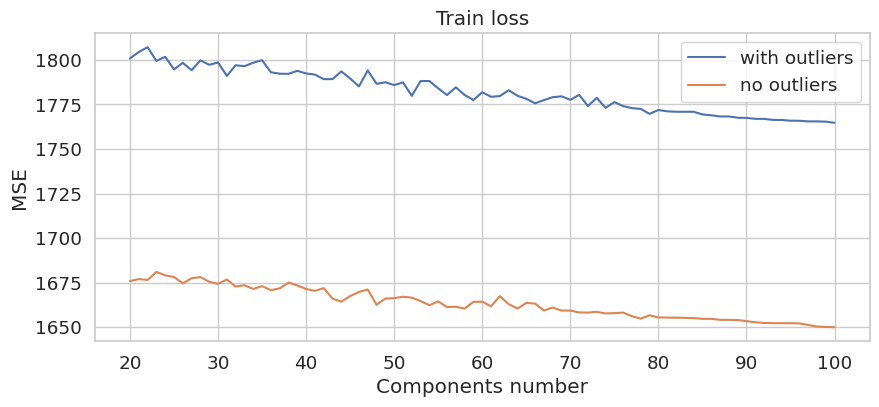

In [71]:
plt.figure(figsize=(10, 4))

plt.plot(components, np.array(loss_list['with outliers'])[:, 0], label='with outliers')
plt.plot(components, np.array(loss_list['no outliers'])[:, 0], label='no outliers')

plt.legend()
plt.title('Train loss')
plt.xlabel('Components number')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

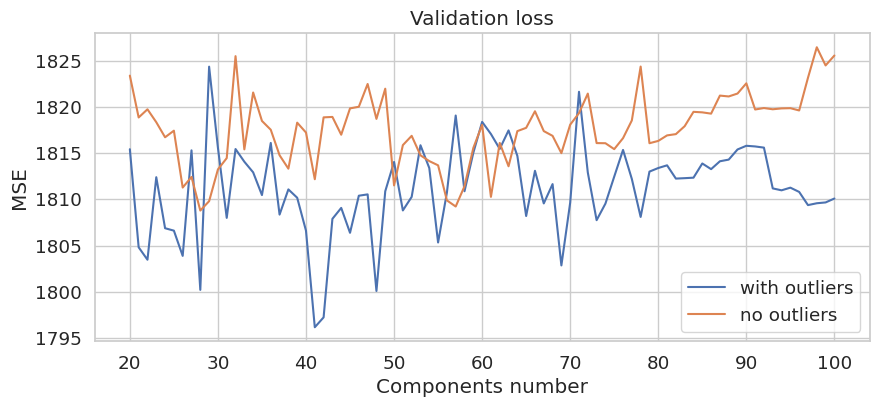

In [72]:
plt.figure(figsize=(10, 4))

plt.plot(components, np.array(loss_list['with outliers'])[:, 1], label='with outliers')
plt.plot(components, np.array(loss_list['no outliers'])[:, 1], label='no outliers')

plt.legend()
plt.title('Validation loss')
plt.xlabel('Components number')
plt.ylabel('MSE')

In [73]:
best_components_number = components[np.argmin(np.array(loss_list['with outliers'])[:, 1])]
print(f"Best components number: {best_components_number}")

Best components number: 41


Видим, что наилучшее значение качества на валидации достигается с использованием первых 41 компонент.

In [74]:
lin_reg_pca_model = models_list[best_components_number]['with outliers']
pca = pca_list[best_components_number]['with outliers']
scaler_pca = scalers_list[best_components_number]['with outliers']

In [75]:
test_df = pd.read_csv("test.csv").drop(columns='Id')
test_features = np.array(test_df)
test_features_pca = pca.transform(test_features)
test_features_pca_scaled = scaler_pca.transform(test_features_pca)
preds = lin_reg_pca_model.predict(test_features_pca_scaled)
prediction = pd.DataFrame(preds, columns=[target]).to_csv(f'prediction_lin_reg_pca.csv', index_label='Id')

Скор на инференсе:

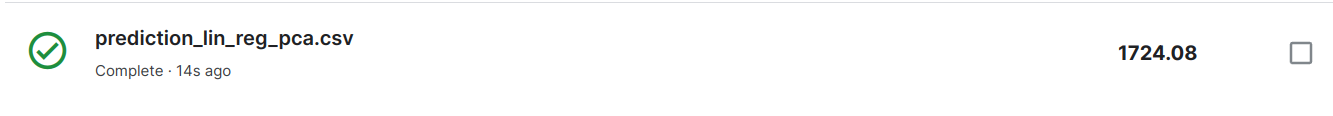

Улучшения скора ожидать не стоило, поскольку график зависимости качества от числа компонент, мягко говоря, не гладкий и говорить о каком-то экстремуме не очень корректно.

### Feature generation

Как показал эксперимент выше, отбор признаков большого прироста в качестве не дал. Можно попробовать сгенерировать новые фичи или использовать стекинг.

### Experiment

#### Стекинг

В качестве базовых моделей, которые генерируют новые признаки, будем использовать градиентный бустинг, линейную регрессию и нейронную сеть. Метамоделью выберем случайный лес.

In [76]:
scaler = StandardScaler()

train_features = np.array(train_data['with outliers'].drop(columns=target))
train_targets = np.array(train_data['with outliers'][target])

train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)

In [77]:
from sklearn.ensemble import RandomForestRegressor

In [78]:
base_model_gb = catboost_regressor

base_model_lr = linear_model

base_model_nn = nn_model
base_model_nn.eval()

meta_model = RandomForestRegressor(n_estimators=100, criterion="squared_error")

Обучим метамодель:

In [79]:
gb_preds = base_model_gb.predict(train_features)[:, None]
lr_preds = base_model_lr['with outliers'].predict(train_features)[:, None]
nn_preds = base_model_nn(torch.Tensor(train_features_scaled).to(device)).detach().cpu()
meta_model.fit(np.hstack((gb_preds, lr_preds, nn_preds)), train_targets)

RandomForestRegressor()

In [80]:
preds = meta_model.predict(np.hstack((gb_preds, lr_preds, nn_preds)))
print(f"Train loss: {np.sqrt(mean_squared_error(preds, train_targets))}")

Train loss: 74.47219245354314


Проверим скор на валидации:

In [81]:
gb_preds = base_model_gb.predict(val_features)[:, None]
lr_preds = base_model_lr['with outliers'].predict(val_features_scaled)[:, None]
nn_preds = base_model_nn(torch.Tensor(val_features_scaled).to(device)).detach().cpu()
preds = meta_model.predict(np.hstack((gb_preds, lr_preds, nn_preds)))
print(f"Val loss: {np.sqrt(mean_squared_error(preds, val_targets))}")

Val loss: 1817.392974799762


Видим, что стекинг переобучился.

In [82]:
test_df = pd.read_csv("test.csv").drop(columns='Id')
test_features = np.array(test_df)
test_features_scaled = scaler.transform(test_features)

In [83]:
gb_preds = base_model_gb.predict(test_features)[:, None]
lr_preds = base_model_lr['with outliers'].predict(test_features_scaled)[:, None]
nn_preds = base_model_nn(torch.Tensor(test_features_scaled).to(device)).detach().cpu()
preds = meta_model.predict(np.hstack((gb_preds, lr_preds, nn_preds)))

In [84]:
prediction = pd.DataFrame(preds, columns=[target]).to_csv(f'prediction_stacking.csv', index_label='Id')

Скор на инференсе:

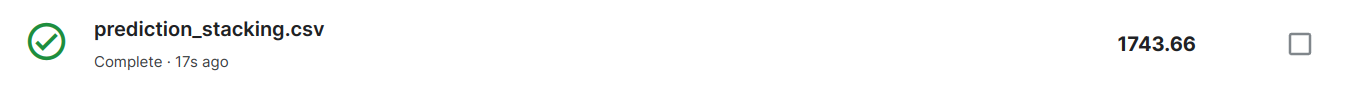

С использованием стекинга мы также не добились увеличения скора, но мы рассмотрели лишь одну возможную архитектуру ансамбля с фиксированными гиперпараметрами у моделей.

## 6) Summary

В ходе выполнения лабораторной работы я попрактиковался в применени различных техник, приёмов, статистических методов и прошёл через основную часть пайплайна решения ML-задачи.

### Сравнение моделей

Для задачи регрессии я использовал три принципиально разных модели: линейную регрессию, градиентный бустинг и нейросеть. Исходное предположение, что градиентный бустинг покажет лучшие результаты, не оправдалось, причём при определённых значениях lr он переобучается и делает идеальные предсказания на трейне. Стоит отметить, что модель нейросети, состояющей из FC-слоёв, переобучить не удалось, хотя я пробовал обучать сети разной глубины, варьируя число параметров. Лучшего качества удалось достичь с использованием модели линейной регрессии, основанной на аналитическом решении задачи.

Попытки соптимизировать результаты модели линейной регрессии успехом не увенчались. Я применил PCA для извлечения наиболее важных фичей, а также пробовал использовать стекинг. Думаю, перебрав ещё несколько различных архитектур для стекинга и подобрав лучшие гиперпараметры при помощи GridSearch, есть все шансы побить текущий скор, но здесь уже встаёт вопрос трейдоффа между временем, которое мы потратим на обучение, и той разницей в скоре (скорее всего маленькой), которую мы получим.

### Итоговый скор на инференсе

Лучшее качество, которого удалось добиться с применением модели линейной регрессии:

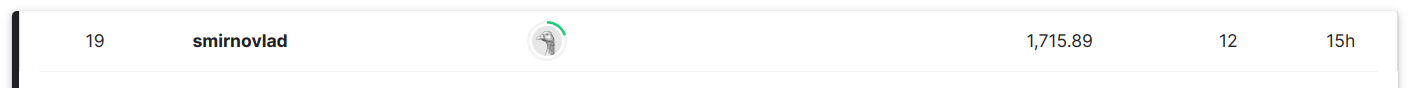

**Замечание.** Ранее я нигде это не отмечал, но возможно стоило обучать модели без валидации (на большем объёме данных) с целью повышения скора на инференсе. Такой подход удачен разве что в соревнованиях на каггле, где можно отправить результаты модели без проверки их корректности (валидации), и в реальной жизни не применим.

### Пару слов от автора

По моему мнению, задача интересна тем, что мы с самого начала работаем с сырыми данными, о которых ничего неизвестно, кроме каких-то численных значений. Мы решаем задачу регрессии с нуля, без каких-либо подсказок о природе данных. Поэтому приходится сравнивать большее число вариантов моделей/архитектур, больше обращаться к статистике $-$ в общем, абсолютно творческое задание.